In [1]:
# %%bash

# # Download TorchVision repo to use some files from
# # references/detection
# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.8.2

# cp references/detection/utils.py ../
# cp references/detection/transforms.py ../
# cp references/detection/coco_eval.py ../
# cp references/detection/engine.py ../
# cp references/detection/coco_utils.py ../


In [2]:
# %%bash

# pip install cython
# # Install pycocotools, the version by default in Colab
# # has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'


In [3]:
# %%bash

# # download the Penn-Fudan dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# # extract it in the current folder
# unzip PennFudanPed.zip


In [4]:
# from PIL import Image
# Image.open('PennFudanPed/PNGImages/FudanPed00001.png')


In [5]:
# mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# # each mask instance has a different color, from zero to N, where
# # N is the number of instances. In order to make visualization easier,
# # let's adda color palette to the mask.
# mask.putpalette([
#     0, 0, 0, # black background
#     255, 0, 0, # index 1 is red
#     255, 255, 0, # index 2 is yellow
#     255, 153, 0, # index 3 is orange
# ])
# mask


In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


DEBUG = True

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

dataset = PennFudanDataset('PennFudanPed/')


In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


In [3]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

# data_loader = torch.utils.data.DataLoader(
#     torch.utils.data.Subset(
#         dataset, 
#         range(0, min(10, len(dataset)))
#     ) if DEBUG else dataset, 
#     batch_size=2, 
#     shuffle=True, 
#     num_workers=4,
#     collate_fn=utils.collate_fn
# )
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions



In [57]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(
        dataset, 
        range(0, min(10, len(dataset)))
    ) if DEBUG else dataset,
    # dataset, 
    batch_size=2, 
    shuffle=True, 
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    torch.utils.data.Subset(
        dataset_test, 
        range(0, min(10, len(dataset_test)))
    ) if DEBUG else dataset_test,
    # dataset_test, 
    batch_size=1, 
    shuffle=False, 
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test_2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(
        dataset_test, 
        range(0, min(10, len(dataset_test)))
    ) if DEBUG else dataset_test,
    # dataset_test, 
    batch_size=1, 
    shuffle=False, 
    num_workers=4,
    collate_fn=utils.collate_fn
)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


In [116]:
def save_checkpoint(model, optimizer, save_path, epoch, loss):
    torch.save(
        {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss
        }, 
        save_path
    )

def load_checkpoint(load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], epoch

def validate(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [118]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1 if DEBUG else 10

checkpoint_path = "maskrcnn.ckpt"


if os.path.exists(checkpoint_path):
    (
        model_state_dict, 
        optimizer_state_dict, 
        epoch_start
    ) = load_checkpoint(load_path)
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
else:
    epoch_start = 0
    loss_min = None

for epoch in range(epoch_start, num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger = train_one_epoch(
        model, 
        optimizer, 
        data_loader,
        device,
        epoch,
        print_freq=2 if DEBUG else 10,
    )
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    loss = validate(data_loader_test)
    print(f"loss={loss}")
    if loss_min is None or loss < loss_min:
        save_checkpoint(model, optimizer, save_path, epoch, loss)
        loss_min = loss
    evaluator = evaluate(
        model,
        data_loader_test,
        device=device
    )


Epoch: [0]  [0/5]  eta: 0:01:08  lr: 0.001254  loss: 0.3532 (0.3532)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.1392 (0.1392)  loss_mask: 0.1759 (0.1759)  loss_objectness: 0.0057 (0.0057)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 13.7678  data: 0.9514
Epoch: [0]  [2/5]  eta: 0:00:37  lr: 0.003751  loss: 0.4552 (0.5752)  loss_classifier: 0.0589 (0.0800)  loss_box_reg: 0.2041 (0.3066)  loss_mask: 0.1759 (0.1709)  loss_objectness: 0.0095 (0.0105)  loss_rpn_box_reg: 0.0066 (0.0073)  time: 12.3634  data: 0.3206
Epoch: [0]  [4/5]  eta: 0:00:10  lr: 0.005000  loss: 0.4552 (0.5267)  loss_classifier: 0.0589 (0.0691)  loss_box_reg: 0.2041 (0.2652)  loss_mask: 0.1759 (0.1757)  loss_objectness: 0.0095 (0.0107)  loss_rpn_box_reg: 0.0057 (0.0060)  time: 10.9927  data: 0.1960
Epoch: [0] Total time: 0:00:55 (11.0720 s / it)
loss=0.5793286830186843


NameError: name 'save_path' is not defined

In [109]:
# val = metric_logger.meters["loss"].value


In [115]:
validate(data_loader_test_2)
# loss_dict

0.6833550423383713

In [114]:
model.train()
for images, targets in data_loader_test_2:
    # images = list(image.to(device) for image in images)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    break

In [98]:
from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os

# loss_dict
# targets

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    # world_size = get_world_size()
    # if world_size < 2:
    #     return input_dict
    with torch.no_grad():
        names = []
        values = []
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

# losses_reduced = reduce_dict(loss_dict)
losses_reduced = sum(loss for loss in loss_dict_reduced.values())
loss_value = losses_reduced.item()

RuntimeError: The size of tensor a (4) must match the size of tensor b (12) at non-singleton dimension 1

In [108]:
# losses = sum(loss for loss in loss_dict.values())
# loss_dict_reduced 
# utils.reduce_dict(loss_dict)
# loss_dict_reduced
# loss_dict_reduced["masks"].shape, loss_dict_reduced["boxes"].shape

(torch.Size([12, 1, 349, 292]), torch.Size([12, 4]))

In [9]:
res = evaluate(
    model,
    data_loader_test,
    device=device
)

creating index...
index created!
Test:  [ 0/10]  eta: 0:00:59  model_time: 5.5450 (5.5450)  evaluator_time: 0.0058 (0.0058)  time: 5.9119  data: 0.3606
Test:  [ 9/10]  eta: 0:00:05  model_time: 5.6495 (5.7659)  evaluator_time: 0.0105 (0.0116)  time: 5.8220  data: 0.0438
Test: Total time: 0:00:58 (5.8331 s / it)
Averaged stats: model_time: 5.6495 (5.7659)  evaluator_time: 0.0105 (0.0116)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.508
 Average R

In [34]:
res.eval_imgs["bbox"][0, 0,0]

{'image_id': 34,
 'category_id': 1,
 'aRng': [0, 10000000000.0],
 'maxDet': 100,
 'dtIds': [1, 2, 3, 4, 5],
 'gtIds': [57],
 'dtMatches': array([[57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]),
 'gtMatches': array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]]),
 'dtScores': [0.16461198031902313,
  0.09843281656503677,
  0.08629433810710907,
  0.07625444233417511,
  0.06801211088895798],
 'gtIgnore': array([0]),
 'dtIgnore': array([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [Fa

In [41]:
# dir(res)
res.eval_imgs["bbox"][0, 1,0]

{'image_id': 34,
 'category_id': 1,
 'aRng': [0, 1024],
 'maxDet': 100,
 'dtIds': [1, 2, 3, 4, 5],
 'gtIds': [57],
 'dtMatches': array([[57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [57.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]),
 'gtMatches': array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.]]),
 'dtScores': [0.16461198031902313,
  0.09843281656503677,
  0.08629433810710907,
  0.07625444233417511,
  0.06801211088895798],
 'gtIgnore': array([1]),
 'dtIgnore': array([[ True,  True, False,  True,  True],
        [ True,  True, False,  True,  True],
        [ True,  True, False,  True,  True],
        [ True,  True, False,  True,  True],
        [ True,  Tru

In [45]:
res.coco_eval["bbox"].eval["scores"].shape#.keys()#["precision"].shape

(10, 101, 1, 4, 3)

In [ ]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# import torchvision.transforms.functional as F


# plt.rcParams["savefig.bbox"] = 'tight'


# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [43]:
# prediction[0]["boxes"]
img

tensor([[[0.4902, 0.4784, 0.4745,  ..., 0.0627, 0.0627, 0.0627],
         [0.4784, 0.4667, 0.4706,  ..., 0.0667, 0.0667, 0.0667],
         [0.4706, 0.4667, 0.4745,  ..., 0.0784, 0.0784, 0.0784],
         ...,
         [0.8431, 0.8118, 0.8000,  ..., 0.8235, 0.8392, 0.8431],
         [0.8588, 0.8314, 0.7843,  ..., 0.8275, 0.8118, 0.7882],
         [0.8627, 0.8627, 0.8000,  ..., 0.8392, 0.7961, 0.7490]],

        [[0.3059, 0.2941, 0.2902,  ..., 0.0706, 0.0706, 0.0706],
         [0.2941, 0.2824, 0.2863,  ..., 0.0745, 0.0745, 0.0745],
         [0.2863, 0.2824, 0.2902,  ..., 0.0863, 0.0863, 0.0863],
         ...,
         [0.8039, 0.7725, 0.7608,  ..., 0.7843, 0.8000, 0.8039],
         [0.8196, 0.7922, 0.7451,  ..., 0.7882, 0.7725, 0.7490],
         [0.8235, 0.8235, 0.7608,  ..., 0.8000, 0.7569, 0.7098]],

        [[0.2431, 0.2314, 0.2275,  ..., 0.0667, 0.0667, 0.0667],
         [0.2314, 0.2196, 0.2235,  ..., 0.0706, 0.0706, 0.0706],
         [0.2235, 0.2196, 0.2275,  ..., 0.0824, 0.0824, 0.

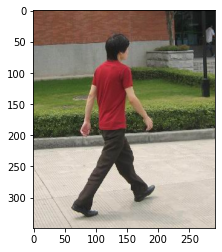

In [44]:
# (img*255).to(torch.uint8)
# from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# draw_segmentation_masks?
# prediction[0]["masks"].squeeze().round().unique()
plt.imshow(img.permute(1,2,0))

In [26]:
# img_res
# to_image = torchvision.transforms.ToPILImage()
# torchvision.utils.save_image(img_res, "result.png")
import cv2
cv2.imwrite(filename="result.png", img=img_res.permute(1,2,0).numpy())

True

In [67]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
from copy import deepcopy


class Vizualizer:
    @staticmethod
    def add_boxes(img, boxes):        
        img_bbox = draw_bounding_boxes(
            image=img,
            boxes=boxes
        )
        return img_bbox

    @staticmethod
    def add_masks(img, masks):
        img_mask = draw_segmentation_masks(
            image=img,
            masks=masks.squeeze().round().to(torch.bool),
            alpha=0.5
        )
        return img_mask

    @classmethod
    def save(cls, img, filepath, boxes=None, masks=None):
        # img = deepcopy(img)
        img = (deepcopy(img) * 255).to(torch.uint8)
        if boxes is not None: img = cls.add_boxes(img, boxes)
        if masks is not None: img = cls.add_masks(img, masks)
        cv2.imwrite(filename=filepath, img=img.permute(1,2,0).numpy())

    @classmethod
    def show(cls, img, boxes=None, masks=None):
        img = (deepcopy(img) * 255).to(torch.uint8)
        if boxes is not None: img = cls.add_boxes(img, boxes)
        if masks is not None: img = cls.add_masks(img, masks)
        plt.imshow(img.permute(1,2,0))


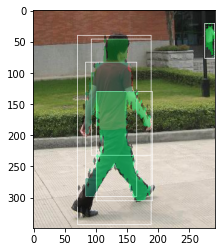

In [70]:
# img_res
# Vizualizer.show(img=img, boxes=prediction[0]["boxes"], masks=prediction[0]["masks"])
Vizualizer.show(img=img, boxes=prediction[0]["boxes"], masks=prediction[0]["masks"])


In [69]:
# prediction[0]#["masks"].shape
Vizualizer.save(
    img=img,
    filepath="result2.png",
    boxes=None,
    masks=prediction[0]["masks"]
)


In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
mask = prediction[0]['masks'][0,0]
Image.fromarray(
    mask.mul(255).byte().cpu().numpy()
)


In [14]:
def draw_prediction(prediction):
    cv2.rectangle(
        image_example_with_anchors,
        (x1, y1),
        (x2, y2),
        np.random.randint(255, size=3).tolist(),
        2
    )
    Image.fromarray(
        prediction['masks'][0, 0]
        .mul(255)
        .byte()
        .cpu()
        .numpy()
    )
